In [1]:
import pandas as pd
import numpy as np
import cv2, os, gc

from glob import glob
##from tqdm import tqdm
from tqdm.notebook import tqdm

import torch

import matplotlib
import matplotlib.pyplot as plt

import os
import gc
import tqdm
import copy
from PIL import Image
import torch
from sklearn.cluster import KMeans
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('train_data.csv')
df['img_name'] = df.apply(lambda row: f"image/{row.patient_id}_{row.image_id}.png", axis=1)
df['img_origin_name'] = df.apply(lambda row: f"archiev/{row.patient_id}_{row.image_id}.png", axis=1)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54659 entries, 0 to 54658
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   site_id                  54659 non-null  int64 
 1   patient_id               54659 non-null  int64 
 2   image_id                 54659 non-null  int64 
 3   laterality               54659 non-null  object
 4   view                     54659 non-null  int64 
 5   age                      54659 non-null  int64 
 6   cancer                   54659 non-null  int64 
 7   biopsy                   54659 non-null  int64 
 8   invasive                 54659 non-null  int64 
 9   BIRADS                   54659 non-null  int64 
 10  implant                  54659 non-null  int64 
 11  density                  54659 non-null  int64 
 12  machine_id               54659 non-null  int64 
 13  difficult_negative_case  54659 non-null  int64 
 14  img_name                 54659 non-nul

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,img_name,img_origin_name
0,2,5,640805896,L,5,68,0,0,0,0,0,255,21,1,image/5_640805896.png,archiev/5_640805896.png
1,2,5,940388076,R,1,68,0,0,0,255,0,255,21,0,image/5_940388076.png,archiev/5_940388076.png
2,2,5,1351088028,L,1,68,0,0,0,0,0,255,21,1,image/5_1351088028.png,archiev/5_1351088028.png
3,2,5,1633417959,R,5,68,0,0,0,255,0,255,21,0,image/5_1633417959.png,archiev/5_1633417959.png
4,1,25,1789648218,L,1,62,0,0,0,1,0,1,49,0,image/25_1789648218.png,archiev/25_1789648218.png


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def kmeans_set_zero(img, dsize=(320,512), num_clusters=4):
    # flatten the image
    img_1d = img.reshape(-1,1)
     
    # apply kmeans
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(img_1d)
    cluster_ids_x = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_

    smallest_sum = np.inf
    smallest_id = 0
    for cluster_id in range(num_clusters):
        cluster_sum = img_1d[cluster_ids_x == cluster_id].sum() / (100000)
        if cluster_sum < smallest_sum:
            smallest_sum = cluster_sum
            smallest_id = cluster_id

    img_1d[cluster_ids_x == smallest_id] = 0    
    kmeans_img = img_1d.reshape(dsize)
    return kmeans_img

def extraxtor_from_roi_box(d, frame, dsize=(512, 320), num_clusters=4):

    h, w = frame.shape
    org_dsize = (h, w)

    frame = kmeans_set_zero(frame, dsize=org_dsize, num_clusters=num_clusters)
    frame_org = copy.copy(frame)

    thres1 = np.min(frame) + 68
    np.place(frame, frame < thres1, 0)

    thres2 = frame_org.sum() / (h * w)
    vertical_not_zero = [True if frame[:, idx].sum() > thres2 else False for idx in range(w)]
    horizontal_not_zero = [True if frame[idx, :].sum() > thres2 else False for idx in range(h)]

    crop = frame_org[horizontal_not_zero, :]
    crop = crop[:, vertical_not_zero]

    crop = cv2.resize(crop, dsize=dsize, interpolation=cv2.INTER_LINEAR)

    return crop

dsize = (320, 512)
org_images = []
images = []
num = 5

for idx in tqdm.tqdm(range(len(df))):
    d = df.iloc[idx]
    img_file = d.img_name
    frame = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
    org_frame = frame.copy()
    crop = extraxtor_from_roi_box(d, frame, dsize=dsize)
    org_images.append(org_frame)
    images.append(crop)

    new_img_name = os.path.join('image/', f"{d.patient_id}_{d.image_id}.png")
    im = Image.fromarray(crop)
    im.save(new_img_name)

fig, axes = plt.subplots(num, num, figsize=(20, 20))
for idx, image in enumerate(org_images):
    i = idx % num
    j = idx // num
    axes[i, j].imshow(image)

plt.subplots_adjust(wspace=0, hspace=.2)
plt.title("Original Images")
plt.show()

fig, axes = plt.subplots(num, num, figsize=(20, 20))
for idx, image in enumerate(images):
    i = idx % num
    j = idx // num
    axes[i, j].imshow(image)

plt.subplots_adjust(wspace=0, hspace=.2)
plt.title("Cropped Images")
plt.show()

del frame, crop, images, image
gc.collect()


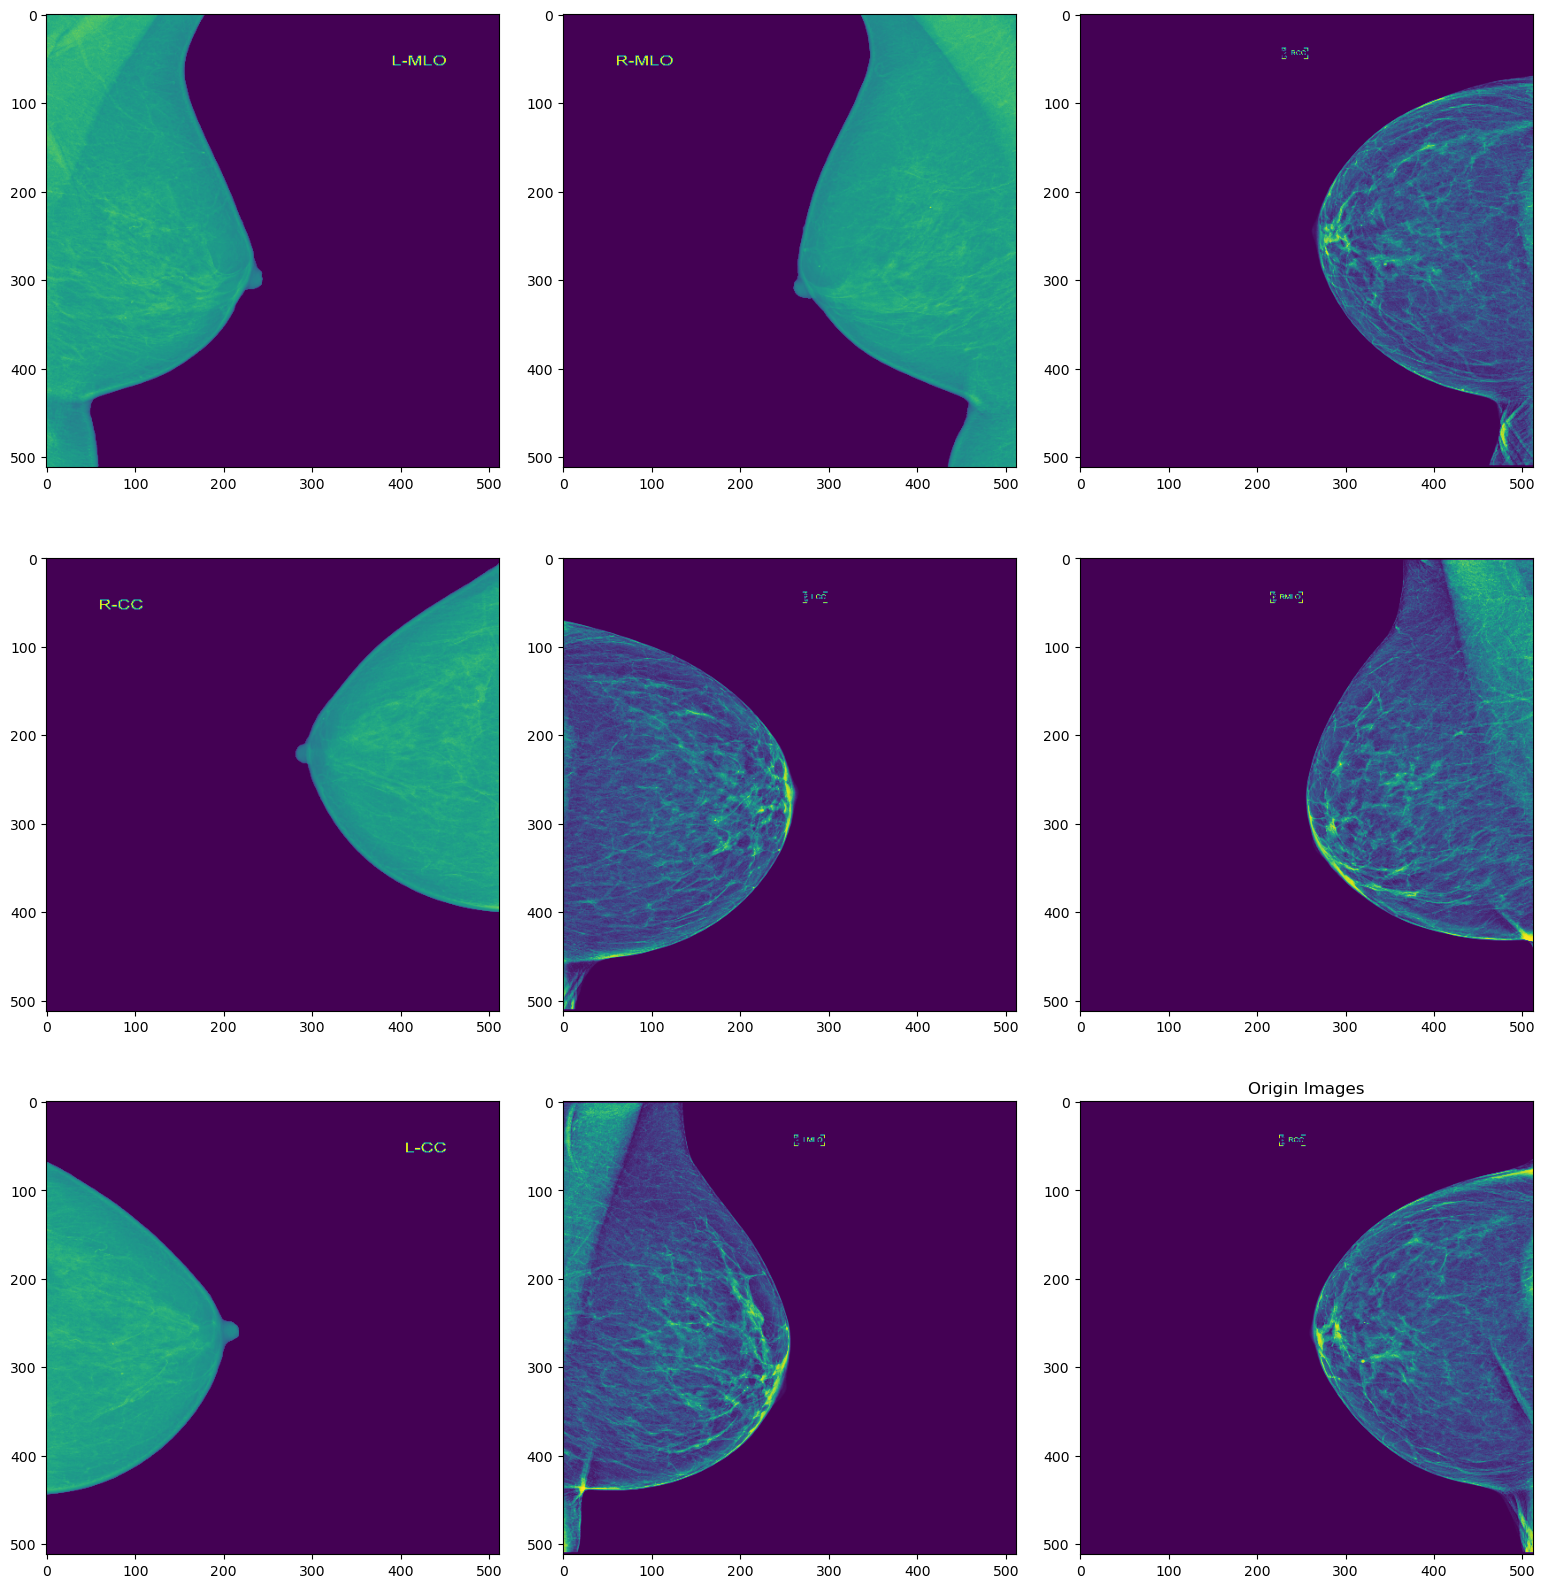

In [17]:
from PIL import Image

num = 3


fig, axes = plt.subplots(num, num, figsize=(20, 20))
for idx in range(num*num):
    new_img_name = os.path.join('archive/', f"{df.iloc[idx]['patient_id']}_{df.iloc[idx]['image_id']}.png")
    crop_img = Image.open(new_img_name)
    crop_img = np.array(crop_img)
    i = idx % num
    j = idx // num
    axes[i, j].imshow(crop_img)
    
plt.subplots_adjust(wspace=0, hspace=.2)
plt.title("Origin Images")
plt.show()



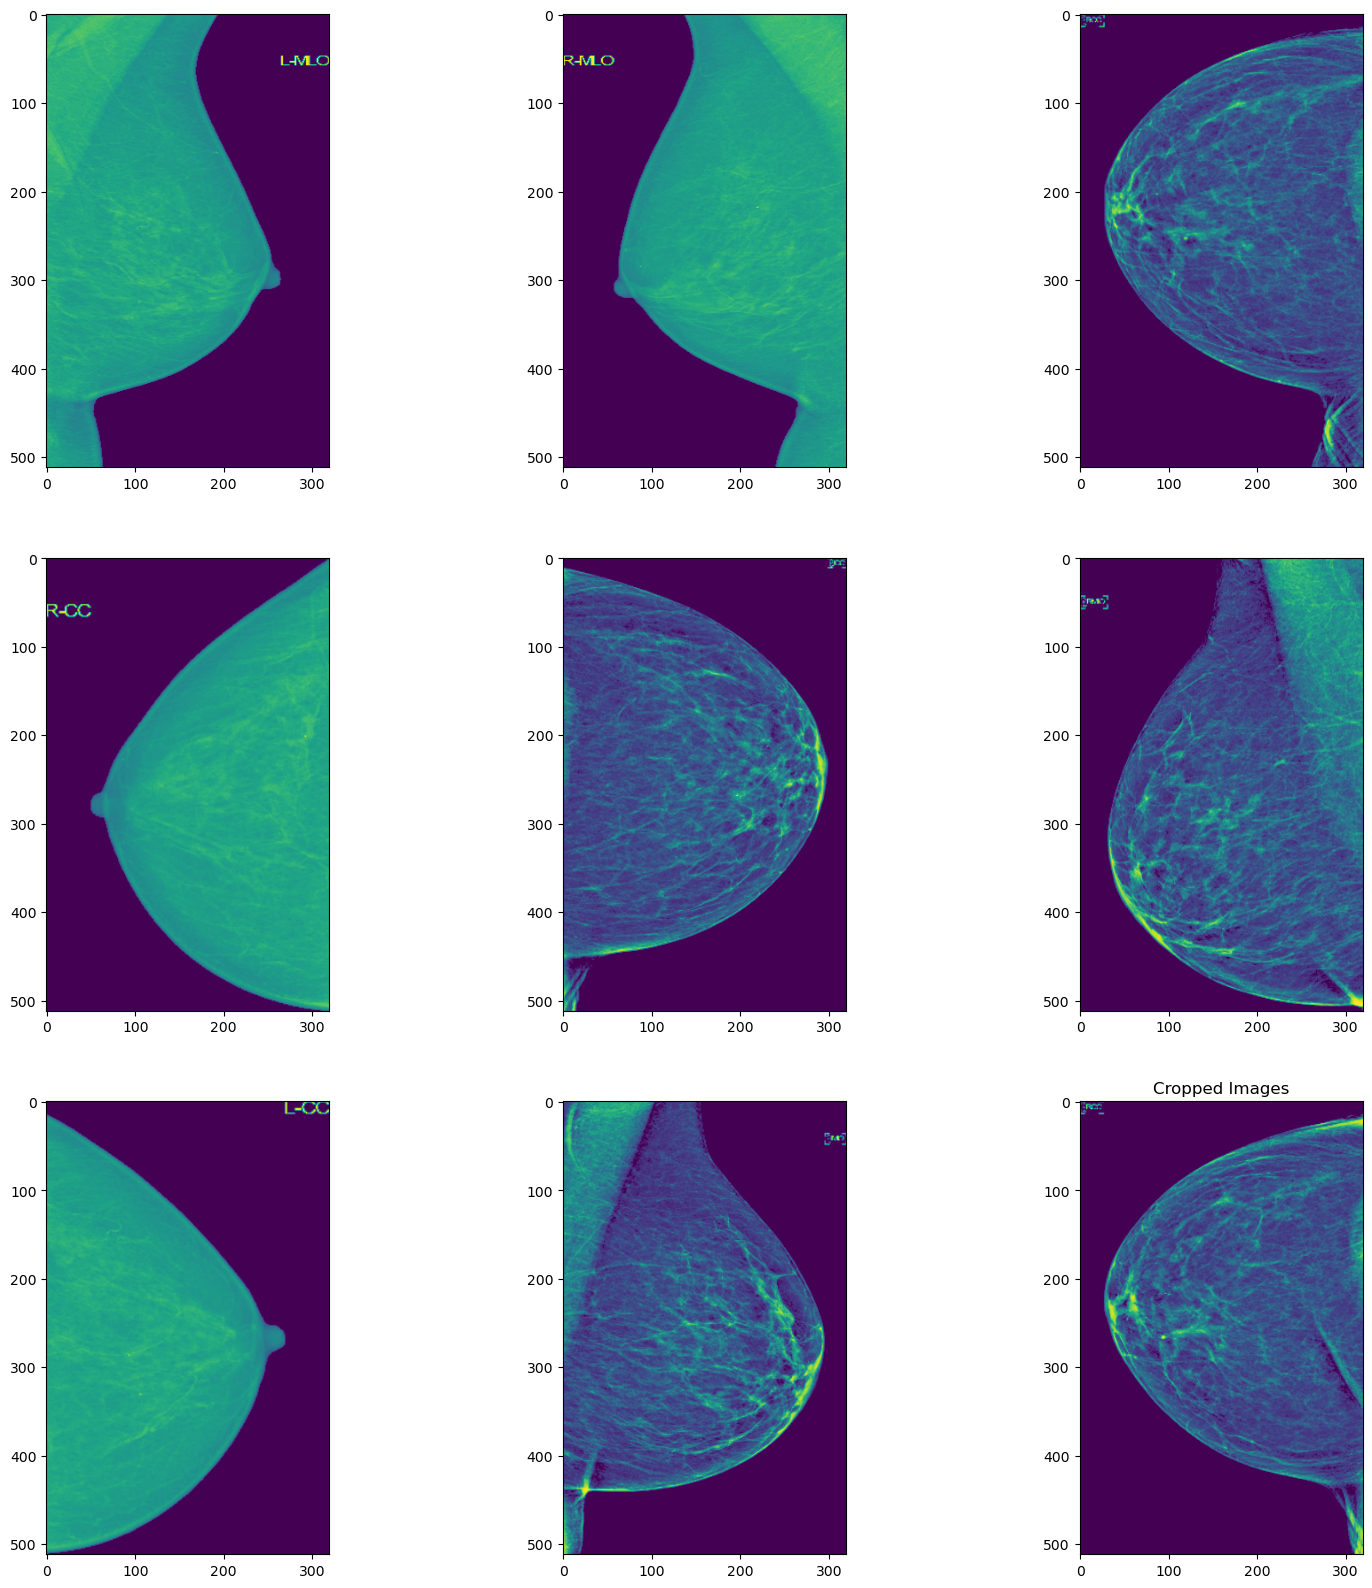

In [13]:
fig, axes = plt.subplots(num, num, figsize=(20, 20))
for idx in range(num*num):
    new_img_name = os.path.join('image/', f"{df.iloc[idx]['patient_id']}_{df.iloc[idx]['image_id']}.png")
    crop_img = Image.open(new_img_name)
    crop_img = np.array(crop_img)
    i = idx % num
    j = idx // num
    axes[i, j].imshow(crop_img)
    
plt.subplots_adjust(wspace=0, hspace=.2)
plt.title("Cropped Images")
plt.show()

